In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import time

# Import file dataset và model bạn vừa sửa
from rtfm_model import RTFM_TFM, Classifier
from rtfm_dataset import RTFMDataset

print("Import thành công. Sẵn sàng train Multi-class.")

c:\Users\LHD\Desktop\PBL6\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import thành công. Sẵn sàng train Multi-class.


In [2]:
# --- Cấu hình ---
device = "cuda" if torch.cuda.is_available() else "cpu"

# Đảm bảo bạn đã có file list (chạy create_lists_stratified.py trước đó)
TRAIN_LIST = Path("feature_lists/rtfm_train.list")
VAL_LIST = Path("feature_lists/rtfm_val.list")

BATCH_SIZE = 60
LEARNING_RATE = 0.001 
EPOCHS = 30
NUM_CLASSES = 14 # 0 là Normal, 1-13 là các loại lỗi

# Đường dẫn model
TFM_MODEL_PATH = Path("rtfm_tfm_model.pth")            # Model Giai đoạn 1 (đã có)
MULTI_CLASS_MODEL_PATH = Path("rtfm_multiclass_model.pth") # Model Giai đoạn 2 (sẽ lưu)

print(f"Thiết bị: {device}")
print(f"Huấn luyện phân loại {NUM_CLASSES} lớp.")

Thiết bị: cpu
Huấn luyện phân loại 14 lớp.


In [3]:
# --- 1. Dataset & DataLoader ---
# Ở giai đoạn 2 Multi-class, ta dùng shuffle=True bình thường, không cần BalancedSampler
train_dataset = RTFMDataset(str(TRAIN_LIST))
val_dataset = RTFMDataset(str(VAL_LIST))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train data: {len(train_dataset)} videos")
print(f"Val data:   {len(val_dataset)} videos")

# --- 2. Load TFM Model (Giai đoạn 1) ---
# Model này dùng để trích xuất đặc trưng mạnh mẽ, ta sẽ đóng băng nó.
tfm_model = RTFM_TFM(input_dim=2048, num_layers=3).to(device)

if TFM_MODEL_PATH.exists():
    state_dict = torch.load(TFM_MODEL_PATH, map_location=device)
    tfm_model.load_state_dict(state_dict)
    print("Đã tải weights TFM Model thành công.")
else:
    print("CẢNH BÁO: Không tìm thấy TFM Model. Đang dùng weights ngẫu nhiên (Hiệu quả sẽ thấp).")

tfm_model.eval()
for p in tfm_model.parameters():
    p.requires_grad = False # Đóng băng (Frozen)

# --- 3. Khởi tạo Classifier Multi-class ---
classifier = Classifier(input_dim=2048, num_classes=NUM_CLASSES).to(device)

# --- 4. Optimizer & Loss ---
optimizer = optim.Adam(classifier.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss() # Hàm loss bắt buộc cho Multi-class

print("Model đã sẵn sàng.")

Train data: 1292 videos
Val data:   318 videos
Đã tải weights TFM Model thành công.
Model đã sẵn sàng.


In [4]:
# Biến lưu lịch sử
history = {
    "train_loss": [],
    "val_accuracy": []
}

print(f"--- BẮT ĐẦU HUẤN LUYỆN ({EPOCHS} Epochs) ---")
start_time = time.time()

for epoch in range(EPOCHS):
    # ================= TRAINING =================
    classifier.train()
    total_loss = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    
    for features, labels in pbar:
        features = features.to(device) # [Batch, 32, C] hoặc [Batch, 32, 10, C]
        labels = labels.to(device)     # [Batch] (giá trị 0-13)
        
        # Fix lỗi 10-crop nếu có
        if features.dim() == 4: 
            features = torch.mean(features, dim=2)
            
        # 1. Trích xuất đặc trưng từ TFM (Đã đóng băng)
        with torch.no_grad():
            robust_features = tfm_model(features) # [Batch, 32, 2048]
            
        # 2. Làm phẳng Features (Flatten)
        # Coi mỗi snippet (đoạn nhỏ) là một mẫu dữ liệu riêng
        # [Batch, 32, 2048] -> [Batch * 32, 2048]
        flat_features = robust_features.reshape(-1, 2048)
        
        # 3. Làm phẳng Labels (Flatten) - ĐÂY LÀ BƯỚC QUAN TRỌNG
        # Labels gốc đang là [Batch] (ví dụ: [1, 5, 0...])
        # Ta cần lặp lại nhãn này cho 32 snippet của mỗi video
        # labels.unsqueeze(1) -> [Batch, 1]
        # .repeat(1, 32)      -> [Batch, 32]
        # .view(-1)           -> [Batch * 32] (Mảng 1 chiều phẳng)
        flat_labels = labels.unsqueeze(1).repeat(1, 32).view(-1)
        
        # 4. Forward qua Classifier
        logits = classifier(flat_features) # Kết quả: [Batch * 32, 14]
        
        # 5. Tính Loss
        # Input: Logits [N, 14], Target: Labels [N] (Long)
        loss = criterion(logits, flat_labels)
        
        # 6. Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")
        
    avg_train_loss = total_loss / len(train_loader)
    history["train_loss"].append(avg_train_loss)
    
    # ================= VALIDATION =================
    classifier.eval()
    correct = 0
    total_videos = 0
    
    with torch.no_grad():
        for features, labels in val_loader:
            features = features.to(device)
            labels = labels.to(device)
            if features.dim() == 4: features = torch.mean(features, dim=2)
            
            robust_features = tfm_model(features) # [Batch, 32, 2048]
            
            # Chiến thuật dự đoán cho Video:
            # 1. Đưa 32 snippet qua classifier
            flat_features = robust_features.reshape(-1, 2048)
            flat_logits = classifier(flat_features) # [Batch * 32, 14]
            
            # 2. Gom lại thành [Batch, 32, 14]
            video_logits_seq = flat_logits.view(features.size(0), 32, NUM_CLASSES)
            
            # 3. Tính trung bình điểm của 32 snippet (Mean Pooling)
            # Để ra 1 vector điểm duy nhất cho cả video: [Batch, 14]
            video_logits_final = torch.mean(video_logits_seq, dim=1)
            
            # 4. Lấy lớp có điểm cao nhất (Argmax)
            _, predicted = torch.max(video_logits_final, 1) # [Batch]
            
            # 5. So sánh với nhãn gốc
            total_videos += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    val_acc = 100 * correct / total_videos if total_videos > 0 else 0
    history["val_accuracy"].append(val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}%")

total_time = time.time() - start_time
print(f"--- HOÀN TẤT ---")
print(f"Tổng thời gian: {total_time/60:.2f} phút")

# Lưu Model
torch.save(classifier.state_dict(), MULTI_CLASS_MODEL_PATH)
print(f"Đã lưu model tại: {MULTI_CLASS_MODEL_PATH}")

--- BẮT ĐẦU HUẤN LUYỆN (30 Epochs) ---


Epoch 1/30 | Loss: 2.3223 | Val Acc: 49.06%


Epoch 2/30 | Loss: 2.0518 | Val Acc: 50.31%


Epoch 3/30 | Loss: 2.0040 | Val Acc: 50.63%


Epoch 4/30 | Loss: 1.8841 | Val Acc: 51.57%


Epoch 5/30 | Loss: 1.8763 | Val Acc: 51.57%


Epoch 6/30 | Loss: 1.8434 | Val Acc: 51.26%


Epoch 7/30 | Loss: 1.8267 | Val Acc: 51.26%


Epoch 8/30 | Loss: 1.8083 | Val Acc: 51.57%


Epoch 9/30 | Loss: 1.7899 | Val Acc: 51.57%


Epoch 10/30 | Loss: 1.7904 | Val Acc: 51.89%


Epoch 11/30 | Loss: 1.7837 | Val Acc: 51.26%


Epoch 12/30 | Loss: 1.7769 | Val Acc: 51.57%


Epoch 13/30 | Loss: 1.7738 | Val Acc: 50.94%


Epoch 14/30 | Loss: 1.7613 | Val Acc: 51.26%


Epoch 15/30 | Loss: 1.7643 | Val Acc: 51.89%


Epoch 16/30 | Loss: 1.7629 | Val Acc: 51.26%


Epoch 17/30 | Loss: 1.7497 | Val Acc: 51.57%


Epoch 18/30 | Loss: 1.7556 | Val Acc: 51.89%


Epoch 19/30 | Loss: 1.7713 | Val Acc: 51.89%


Epoch 20/30 | Loss: 1.7473 | Val Acc: 51.26%


Epoch 21/30 | Loss: 1.7293 | Val Acc: 51.57%


Epoch 22/30 | Loss: 1.7264 | Val Acc: 51.57%


Epoch 23/30 | Loss: 1.7286 | Val Acc: 51.26%


Epoch 24/30 | Loss: 1.7217 | Val Acc: 51.57%


Epoch 25/30 | Loss: 1.7261 | Val Acc: 51.26%


Epoch 26/30 | Loss: 1.7486 | Val Acc: 51.57%


Epoch 27/30 | Loss: 1.7273 | Val Acc: 51.57%


Epoch 28/30 | Loss: 1.7242 | Val Acc: 51.26%


Epoch 29/30 | Loss: 1.7343 | Val Acc: 51.89%


Epoch 30/30 | Loss: 1.7330 | Val Acc: 51.57%
--- HOÀN TẤT ---
Tổng thời gian: 48.03 phút
Đã lưu model tại: rtfm_multiclass_model.pth


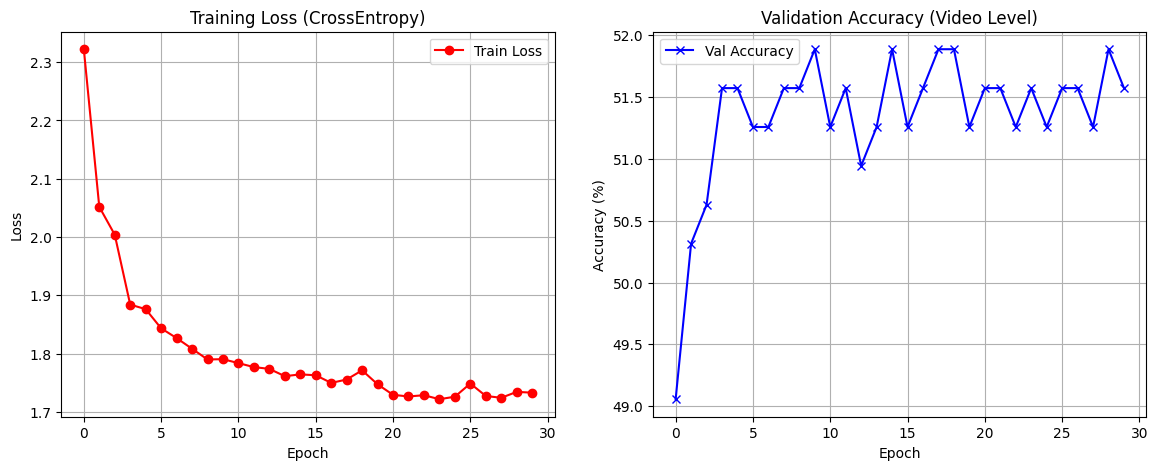

In [5]:
# Vẽ biểu đồ Loss và Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Biểu đồ Loss
ax1.plot(history["train_loss"], color='red', marker='o', label='Train Loss')
ax1.set_title("Training Loss (CrossEntropy)")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

# Biểu đồ Accuracy
ax2.plot(history["val_accuracy"], color='blue', marker='x', label='Val Accuracy')
ax2.set_title("Validation Accuracy (Video Level)")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.grid(True)
ax2.legend()

plt.show()